In [1]:
import pandas as pd
import numpy as np
from pathlib import Path




import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import missingno as msno
from plotly.colors import DEFAULT_PLOTLY_COLORS as colors


from utils import get_idle_proportion
from constant import MAP_TIME_COL, NODE_TO_PARTITION_NAME

from sklearn import set_config
set_config(transform_output = "pandas")

In [2]:
"""" 
                                        ***ML BASED ON PURE SINFO DATA: Classic ML Models ***


"""


'" \n                                        ***ML BASED ON PURE SINFO DATA: Classic ML Models ***\n\n\n'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_prom_data = Path('/projects/2/prjs1098/system_analytics_2024/prom_data')
folder_path_EAR_data = Path('/projects/2/prjs1098/system_analytics_2024/ear_data')

folder_path_saving_results = Path('./results')

all_prom_file_paths = list(folder_path_prom_data.glob("*.gzip"))
# for getting the up-to-date data run the clenaing_sinfo file
# with the latest data from the system.
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_EDA_cleaned.parquet.gzip')
df.sample(n=5)

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_4hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval
365,tcn1082,2024-11-16 16:37:13,idle,tcn,2024-11-16 16:30:00,2024-11-16 16:00:00,2024-11-16 16:00:00,2024-11-16 15:00:00,2024-11-16 16:00:00,2024-11-16 12:00:00,2024-11-16 12:00:00,2024-11-16
48,tcn429,2024-11-22 22:37:44,mixed,tcn,2024-11-22 22:30:00,2024-11-22 22:00:00,2024-11-22 22:00:00,2024-11-22 21:00:00,2024-11-22 20:00:00,2024-11-22 18:00:00,2024-11-22 12:00:00,2024-11-22
158,tcn247,2024-11-05 01:20:52,allocated,tcn,2024-11-05 01:00:00,2024-11-05 01:00:00,2024-11-05 00:00:00,2024-11-05 00:00:00,2024-11-05 00:00:00,2024-11-05 00:00:00,2024-11-05 00:00:00,2024-11-05
207,tcn401,2024-11-19 07:41:05,allocated,tcn,2024-11-19 07:30:00,2024-11-19 07:00:00,2024-11-19 06:00:00,2024-11-19 06:00:00,2024-11-19 04:00:00,2024-11-19 06:00:00,2024-11-19 00:00:00,2024-11-19
49,tcn900,2024-12-08 07:10:24,mixed,tcn,2024-12-08 07:00:00,2024-12-08 07:00:00,2024-12-08 06:00:00,2024-12-08 06:00:00,2024-12-08 04:00:00,2024-12-08 06:00:00,2024-12-08 00:00:00,2024-12-08


In [4]:
# WHICH TIME INTEVAL MAKES SENSE FOR ML?
time_col = 'time_4hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# show a smaple
initial_data_size= len(df_stat)
display(df_stat.sample(n=5))
print(initial_data_size)
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

# note the trick here! this happens again in the future for Promethues data
df_last = df.groupby(['node', time_col], as_index=False)[['node', time_col, 'state', 'time']].tail(1).copy()
# merge it with the main
df_stat = pd.merge(df_stat, df_last[['node', time_col, 'state', 'time']],
                   how='left', on=['node', time_col]).copy()
# rename it
df_stat.rename(columns={'time':'time_for_last_state', 'state': 'last_state'}, inplace=True)
# show a sample
display(df_stat.sample(n=10))
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

,node,time_4hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
207191,tcn485,2024-11-22 20:00:00,0 days 03:58:41,0 days 03:58:41,1.0
155987,tcn269,2024-11-13 04:00:00,0 days 00:00:00,0 days 03:59:24,0.0
189844,tcn411,2024-11-20 16:00:00,0 days 00:00:00,0 days 03:59:21,0.0
203736,tcn470,2024-11-17 16:00:00,0 days 03:58:27,0 days 03:58:27,1.0
181252,tcn376,2024-11-15 08:00:00,0 days 00:00:00,0 days 03:59:24,0.0


329062
Is there duplication in node and time: False


,node,time_4hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,last_state,time_for_last_state
40796,gcn2,2024-11-27 08:00:00,0 days 00:00:00,0 days 03:59:12,0.0000,mixed,2024-11-27 11:59:29
296114,tcn860,2024-11-06 00:00:00,0 days 03:59:12,0 days 03:59:12,1.0000,idle,2024-11-06 03:59:40
226023,tcn565,2024-11-22 20:00:00,0 days 00:00:00,0 days 03:58:41,0.0000,allocated,2024-11-22 23:59:52
210918,tcn50,2024-12-07 16:00:00,0 days 03:58:44,0 days 03:58:44,1.0000,idle,2024-12-07 19:59:29
20885,fcn79,2024-11-25 20:00:00,0 days 03:59:18,0 days 03:59:18,1.0000,idle,2024-11-25 23:59:40
304994,tcn898,2024-11-23 16:00:00,0 days 03:59:30,0 days 03:59:30,1.0000,idle,2024-11-23 19:59:35
121484,tcn126,2024-11-05 00:00:00,0 days 00:00:00,0 days 03:59:20,0.0000,allocated,2024-11-05 03:59:33
318353,tcn953,2024-12-08 20:00:00,0 days 00:00:00,0 days 03:58:13,0.0000,allocated,2024-12-08 23:59:53
236383,tcn608,2024-12-07 12:00:00,0 days 01:50:04,0 days 03:58:41,0.4611,idle,2024-12-07 15:59:20
2541,fcn109,2024-12-05 20:00:00,0 days 03:58:22,0 days 03:58:22,1.0000,idle,2024-12-05 23:59:13


Is there duplication in node and time: False


In [5]:
df_stat.sort_values(['node', time_col], inplace=True)
# drop some columns
df_stat.drop(['idle_duration', 'all_state_durations_in_interval'],
             axis=1, inplace=True)
df_stat.head()


,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state
0,fcn1,2024-11-04 16:00:00,0.0,mixed,2024-11-04 19:59:37
1,fcn1,2024-11-04 20:00:00,0.0,mixed,2024-11-04 23:59:43
2,fcn1,2024-11-05 00:00:00,0.0,mixed,2024-11-05 03:59:33
3,fcn1,2024-11-05 04:00:00,0.0,mixed,2024-11-05 07:59:32
4,fcn1,2024-11-05 08:00:00,0.0,mixed,2024-11-05 11:59:33


Top 5 nodes with nan values: 
      node
gcn56     35
gcn25     35
fcn1       0
tcn542     0
tcn541     0
dtype: int64


<Axes: >

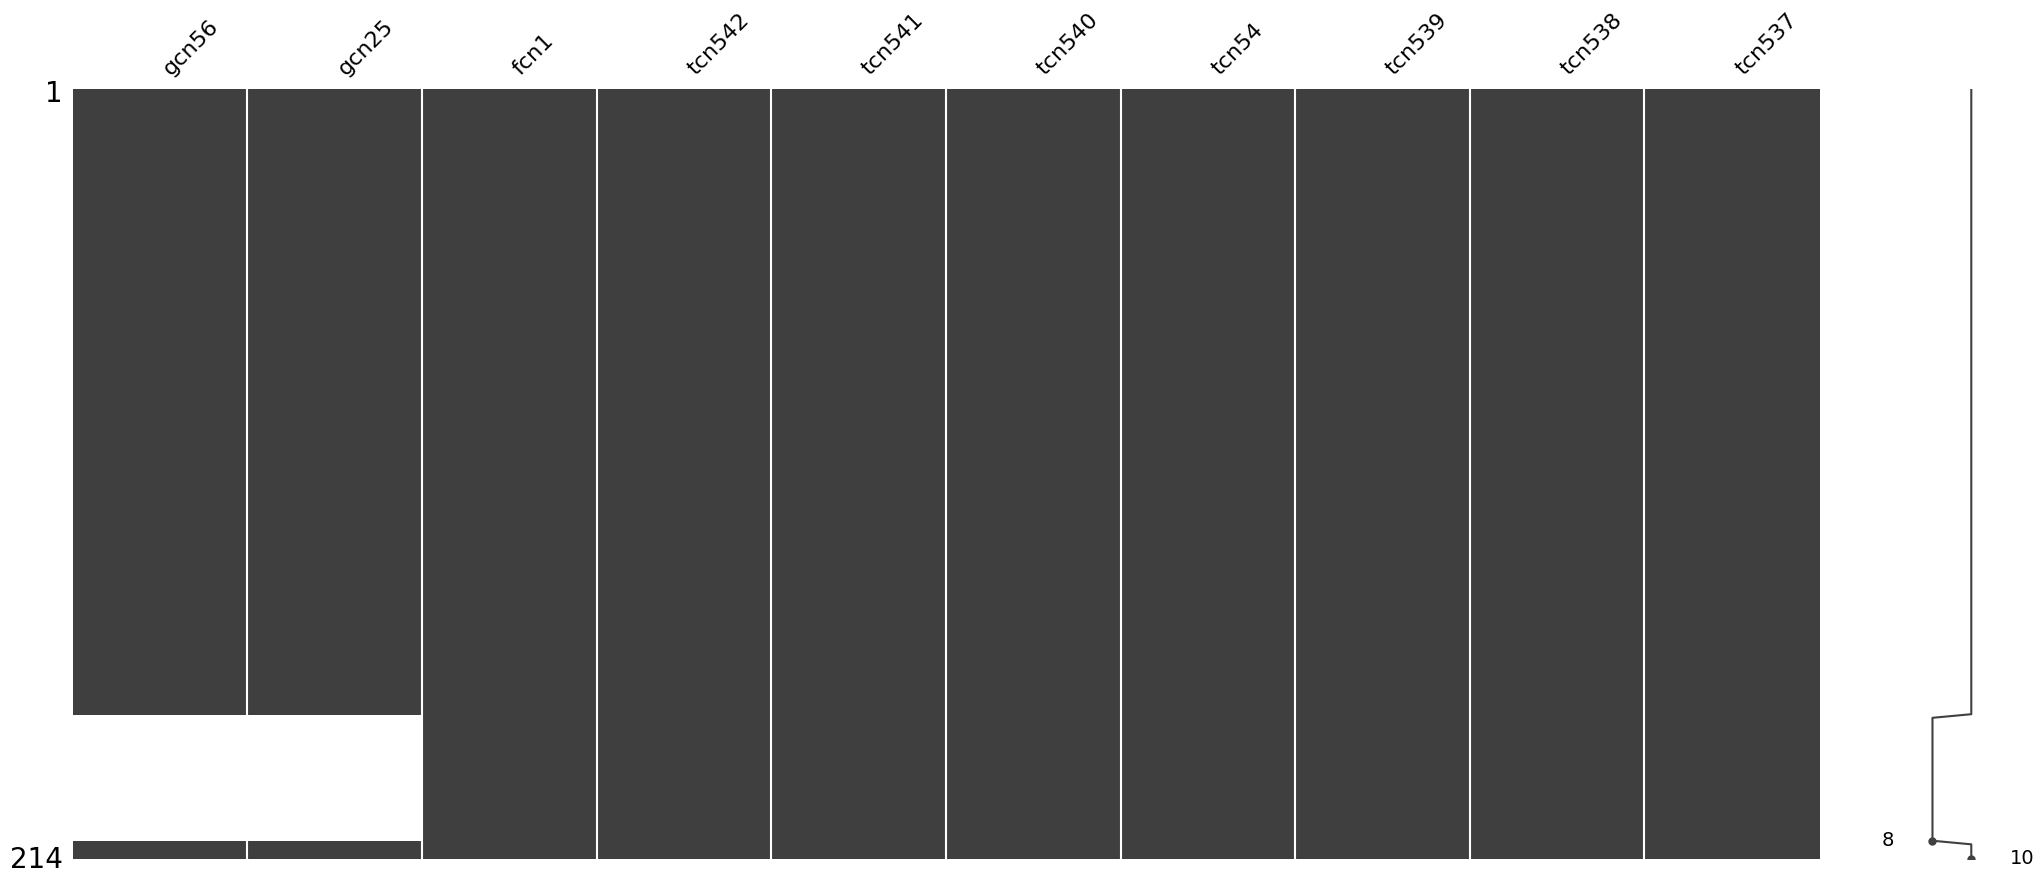

In [6]:
# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
# df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d")

print(f"""Top 5 nodes with nan values: 
      {df_stat_pivot.isna().sum().sort_values(ascending=False).head()}""")
node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_sorted_nodes.iloc[:, 0:10])

# we have nan values in the idle proportion!==> it seems that this has happened recently and two of the nodes are not
# showing any state values



In [7]:
"""  
Drop the nodes that have really bad nan values
"""
mask = (df_stat['node'] == 'gcn56') | (df_stat['node'] == 'gcn25')
df_stat = df_stat[~mask].copy()

# Feature enginnering


Add new features to the data


In [8]:
# add the lags here; 
time_sample_in_one_day = pd.Timedelta('1day') // MAP_TIME_COL[time_col]

lags = (
    (np.arange(3) + 1).tolist()
    + (np.arange(3) + (time_sample_in_one_day-2)).tolist()
    + (np.arange(3) + (time_sample_in_one_day * 7) - 2).tolist()
)

for i in lags:
    df_stat[f'lag_{i}'] = df_stat.groupby('node', as_index=False)['idle_proportion'].shift(i)
    
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_40,lag_41,lag_42
42665,gcn28,2024-11-23 16:00:00,0.0,allocated,2024-11-23 19:59:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42666,gcn28,2024-11-23 20:00:00,0.0,allocated,2024-11-23 23:59:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42667,gcn28,2024-11-24 00:00:00,0.0,mixed,2024-11-24 03:59:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42668,gcn28,2024-11-24 04:00:00,0.0,mixed,2024-11-24 07:59:54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42669,gcn28,2024-11-24 08:00:00,0.0,allocated,2024-11-24 11:59:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42670,gcn28,2024-11-24 12:00:00,0.0,allocated,2024-11-24 15:59:41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42671,gcn28,2024-11-24 16:00:00,0.0,mixed,2024-11-24 19:58:57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42672,gcn28,2024-11-24 20:00:00,0.0,mixed,2024-11-24 23:59:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42673,gcn28,2024-11-25 00:00:00,0.0,mixed,2024-11-25 03:59:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42674,gcn28,2024-11-25 04:00:00,0.0,mixed,2024-11-25 07:59:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# adding aggreation to the signals
rolls = [3 * time_sample_in_one_day, 2 * time_sample_in_one_day,  time_sample_in_one_day]
agg_functions = ['mean', 'std']

for agg_function in agg_functions:
    for roll in rolls:
        df_stat[f'roll_{roll}_{agg_function}'] = (df_stat
                                                  .groupby('node', as_index=False)['idle_proportion']
                                                  .shift(1) # shift to avoid leakage!
                                                  .rolling(roll)
                                                  .agg(agg_function))
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_40,lag_41,lag_42,roll_18_mean,roll_12_mean,roll_6_mean,roll_18_std,roll_12_std,roll_6_std
79445,tcn1082,2024-11-24 20:00:00,1.0,idle,2024-11-24 23:59:02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79446,tcn1082,2024-11-25 00:00:00,1.0,idle,2024-11-25 03:59:08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79447,tcn1082,2024-11-25 04:00:00,1.0,idle,2024-11-25 07:59:13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79448,tcn1082,2024-11-25 08:00:00,1.0,idle,2024-11-25 11:59:37,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79449,tcn1082,2024-11-25 12:00:00,1.0,idle,2024-11-25 15:59:27,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79450,tcn1082,2024-11-25 16:00:00,1.0,idle,2024-11-25 19:59:34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79451,tcn1082,2024-11-25 20:00:00,1.0,idle,2024-11-25 23:59:40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79452,tcn1082,2024-11-26 00:00:00,1.0,idle,2024-11-26 03:59:45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79453,tcn1082,2024-11-26 04:00:00,1.0,idle,2024-11-26 07:59:50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
79454,tcn1082,2024-11-26 08:00:00,1.0,idle,2024-11-26 11:59:58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [10]:
# add calender feature like day of the week and month
df_stat['hour_day'] = df_stat[time_col].dt.hour
df_stat['week_day'] = df_stat[time_col].dt.day_of_week
# df_stat['month'] = df_stat[time_col].dt.month

# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_40,lag_41,lag_42,roll_18_mean,roll_12_mean,roll_6_mean,roll_18_std,roll_12_std,roll_6_std,hour_day,week_day
61197,tcn1005,2024-11-15 04:00:00,1.0,idle,2024-11-15 07:59:04,1.0,1.0,0.8195,0.9163,1.0000,1.0000,1.0,1.0,1.0,0.9852,0.978,0.9560,0.0458,0.0554,0.0748,4,4
61198,tcn1005,2024-11-15 08:00:00,1.0,idle,2024-11-15 11:59:28,1.0,1.0,1.0000,0.8195,0.9163,1.0000,1.0,1.0,1.0,0.9852,0.978,0.9560,0.0458,0.0554,0.0748,8,4
61199,tcn1005,2024-11-15 12:00:00,1.0,idle,2024-11-15 15:59:49,1.0,1.0,1.0000,1.0000,0.8195,0.9163,1.0,1.0,1.0,0.9852,0.978,0.9560,0.0458,0.0554,0.0748,12,4
61200,tcn1005,2024-11-15 16:00:00,1.0,idle,2024-11-15 19:59:12,1.0,1.0,1.0000,1.0000,1.0000,0.8195,1.0,1.0,1.0,0.9852,0.978,0.9699,0.0458,0.0554,0.0737,16,4
61201,tcn1005,2024-11-15 20:00:00,1.0,idle,2024-11-15 23:59:36,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.978,1.0000,0.0458,0.0554,0.0000,20,4
61202,tcn1005,2024-11-16 00:00:00,1.0,idle,2024-11-16 03:59:59,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.978,1.0000,0.0458,0.0554,0.0000,0,5
61203,tcn1005,2024-11-16 04:00:00,1.0,idle,2024-11-16 07:59:22,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.978,1.0000,0.0458,0.0554,0.0000,4,5
61204,tcn1005,2024-11-16 08:00:00,1.0,idle,2024-11-16 11:59:46,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.978,1.0000,0.0458,0.0554,0.0000,8,5
61205,tcn1005,2024-11-16 12:00:00,1.0,idle,2024-11-16 15:59:10,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.978,1.0000,0.0458,0.0554,0.0000,12,5
61206,tcn1005,2024-11-16 16:00:00,1.0,idle,2024-11-16 19:59:39,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.9853,0.985,1.0000,0.0458,0.0521,0.0000,16,5


In [11]:
# add parition name, use the map from constant
df_stat['partition'] = (df_stat['node']
                        .apply(lambda x: NODE_TO_PARTITION_NAME
                               .get(x, 'other')))
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_40,lag_41,lag_42,roll_18_mean,roll_12_mean,roll_6_mean,roll_18_std,roll_12_std,roll_6_std,hour_day,week_day,partition
111205,tcn1215,2024-12-09 12:00:00,1.0,idle,2024-12-09 15:59:51,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,12,0,AMD_GENOA
111206,tcn1215,2024-12-09 16:00:00,1.0,idle,2024-12-09 19:59:59,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,16,0,AMD_GENOA
111207,tcn1215,2024-12-09 20:00:00,1.0,idle,2024-12-09 23:59:50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,20,0,AMD_GENOA
111208,tcn1215,2024-12-10 00:00:00,1.0,idle,2024-12-10 03:59:59,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,1,AMD_GENOA
111209,tcn1215,2024-12-10 04:00:00,1.0,idle,2024-12-10 07:34:13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4,1,AMD_GENOA
111210,tcn1216,2024-11-04 16:00:00,1.0,idle,2024-11-04 19:59:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0,AMD_GENOA
111211,tcn1216,2024-11-04 20:00:00,1.0,idle,2024-11-04 23:59:43,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,0,AMD_GENOA
111212,tcn1216,2024-11-05 00:00:00,1.0,idle,2024-11-05 03:59:33,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AMD_GENOA
111213,tcn1216,2024-11-05 04:00:00,1.0,idle,2024-11-05 07:59:32,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,AMD_GENOA
111214,tcn1216,2024-11-05 08:00:00,1.0,idle,2024-11-05 11:59:33,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1,AMD_GENOA


In [ ]:
# shifting the last state to avoid data leakage.
df_stat['last_state_lag_1'] = (df_stat
                               .groupby('node', as_index=False)['last_state']
                               .shift(1))
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

,node,time_4hour_interval,idle_proportion,last_state,time_for_last_state,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_40,lag_41,lag_42,roll_18_mean,roll_12_mean,roll_6_mean,roll_18_std,roll_12_std,roll_6_std,hour_day,week_day,partition,last_state_lag_1
10762,fcn36,2024-11-15 00:00:00,0.0000,mixed,2024-11-15 03:59:44,0.0000,0.7562,0.9958,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.6902,0.8960,0.7920,0.4334,0.2907,0.4000,0,4,fcn_nodes,mixed
10763,fcn36,2024-11-15 04:00:00,0.9874,idle,2024-11-15 07:59:04,0.0000,0.0000,0.7562,0.9958,1.0000,1.0000,1.0,1.0,1.0,0.6902,0.8127,0.6253,0.4334,0.3859,0.4934,4,4,fcn_nodes,mixed
10764,fcn36,2024-11-15 08:00:00,1.0000,idle,2024-11-15 11:59:28,0.9874,0.0000,0.0000,0.7562,0.9958,1.0000,1.0,1.0,1.0,0.7451,0.8116,0.6232,0.4023,0.3854,0.4915,8,4,fcn_nodes,idle
10765,fcn36,2024-11-15 12:00:00,1.0000,idle,2024-11-15 15:59:49,1.0000,0.9874,0.0000,0.0000,0.7562,0.9958,1.0,1.0,1.0,0.7846,0.8116,0.6232,0.3895,0.3854,0.4915,12,4,fcn_nodes,idle
10766,fcn36,2024-11-15 16:00:00,1.0000,idle,2024-11-15 19:59:12,1.0000,1.0000,0.9874,0.0000,0.0000,0.7562,1.0,1.0,1.0,0.8209,0.8116,0.6239,0.3766,0.3854,0.4922,16,4,fcn_nodes,idle
10767,fcn36,2024-11-15 20:00:00,1.0000,idle,2024-11-15 23:59:36,1.0000,1.0000,1.0000,0.9874,0.0000,0.0000,1.0,1.0,1.0,0.8744,0.8116,0.6646,0.3232,0.3854,0.5148,20,4,fcn_nodes,idle
10768,fcn36,2024-11-16 00:00:00,1.0000,idle,2024-11-16 03:59:59,1.0000,1.0000,1.0000,1.0000,0.9874,0.0000,1.0,1.0,1.0,0.8744,0.8116,0.8312,0.3232,0.3854,0.4073,0,5,fcn_nodes,idle
10769,fcn36,2024-11-16 04:00:00,1.0000,idle,2024-11-16 07:59:22,1.0000,1.0000,1.0000,1.0000,1.0000,0.9874,1.0,1.0,1.0,0.8744,0.8116,0.9979,0.3232,0.3854,0.0051,4,5,fcn_nodes,idle
10770,fcn36,2024-11-16 08:00:00,1.0000,idle,2024-11-16 11:59:46,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.8744,0.8116,1.0000,0.3232,0.3854,0.0000,8,5,fcn_nodes,idle
10771,fcn36,2024-11-16 12:00:00,1.0000,idle,2024-11-16 15:59:10,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,0.8744,0.8116,1.0000,0.3232,0.3854,0.0000,12,5,fcn_nodes,idle


In [ ]:
"""   
We biring the data about the number of jobs that happend before at the same day last year or last quarter ...
"""
df_job_number_history = pd.read_parquet(folder_path_EAR_data / 'job_number_history_cleaned.parquet.gzip')
df_temp = df_job_number_history.groupby(['job_start_time_date'], as_index=False)['job_id'].aggregate(['nunique'])

df_temp.head()
# df_temp and add it  create a nice feature to use

'  \n1) Bring data from EAR for number of jobs that was running in the previous time step ==> Do it carefully, there should be no leakage\n2) Also use the history of EAR and add a column which shows the number of jobs last year the same time, in the whole system\n2) Bring data from Prom for the signals ==> Do it carefully there should be no leakage\n'

In [ ]:

"""  
1) Bring data from EAR for number of jobs that was running in the previous time step ==> Do it carefully, there should be no leakage
2) Also use the history of EAR and add a column which shows the number of jobs last year the same time, in the whole system
3) Bring data from Prom for the signals ==> Do it carefully there should be no leakage
"""

In [14]:
# drop columns that are not useful or lead to data leakage or ...
df_stat.drop(['last_state', 'time_for_last_state'],
             axis=1, inplace=True)

# rename idle_proportion to target
df_stat.rename(columns={'idle_proportion':'target'}, inplace=True)

# Train Test Valildation Split


The final week in the data for test and the week before that is for validation


In [15]:
TEST_DATA_LENGTH = pd.Timedelta('7days')
VAL_DATA_LENGTH = pd.Timedelta('7days')

test_upper_bound = df_stat[time_col].max()
test_lower_bound = test_upper_bound - TEST_DATA_LENGTH

val_upper_bound = test_lower_bound - MAP_TIME_COL[time_col]
val_lower_bound = val_upper_bound - VAL_DATA_LENGTH


val_mask = (val_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=val_upper_bound)
test_mask = (test_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=test_upper_bound)
train = df_stat[~(val_mask|test_mask)]
val = df_stat[val_mask]
test = df_stat[test_mask]



print(f"""val lower bound:{val_lower_bound}, val upper bound:{val_upper_bound}, test lower bound:{test_lower_bound}, 
      test lower bound: {test_upper_bound}""")
print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"""Max Date in Train: {train[time_col].max()} | Min Date in Validation: {val[time_col].min()}|  Max Date in Validation: {val[time_col].max()}|
      Min Date in Test: {test[time_col].min()}| Max Date in Test: {test[time_col].max()}""")


val lower bound:2024-11-26 00:00:00, val upper bound:2024-12-03 00:00:00, test lower bound:2024-12-03 04:00:00, 
      test lower bound: 2024-12-10 04:00:00
# of Training samples: 196608 | # of Validation samples: 66048 | # of Test samples: 66048
Max Date in Train: 2024-11-25 20:00:00 | Min Date in Validation: 2024-11-26 00:00:00|  Max Date in Validation: 2024-12-03 00:00:00|
      Min Date in Test: 2024-12-03 04:00:00| Max Date in Test: 2024-12-10 04:00:00


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn import set_config
set_config(transform_output = "default")


In [17]:
# preprocessing the data


X_train = train.iloc[:, 3:]
y_train = train.iloc[:,0:3]

X_val = val.iloc[:,3:]
y_val = val.iloc[:,0:3]

X_test = test.iloc[:,3:]
y_test = test.iloc[:,0:3]


categorical_column = ['hour_day', 'week_day','partition', 'last_state_lag_1']

transformer = make_column_transformer(
    # (StandardScaler(), ['numerical_column']),
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), categorical_column),
    remainder='passthrough')


# transoform the data
X_train_trans = transformer.fit_transform(X_train)
X_val_trans = transformer.transform(X_val)
X_test_trans = transformer.transform(X_test)
print(X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)

X_train_trans = pd.DataFrame(X_train_trans)
X_val_trans = pd.DataFrame(X_val_trans)
X_test_trans = pd.DataFrame(X_test_trans)



X_train_trans.bfill(inplace=True)
X_val_trans.bfill(inplace=True)
X_test_trans.bfill(inplace=True)





(196608, 53) (66048, 53) (66048, 53)


In [18]:
"""    
Naive one step ahead prediction, use the previous value as your prediction
Naive seasnoal prediction: get the value of previous week excatly the same time and say that this is my prediction
"""
y_train['label'] = 'train'
y_val['label'] = 'val'
y_test['label'] = 'test'

train_val_test_concat = pd.concat([y_train, y_val, y_test], axis=0)
train_val_test_concat.sort_values(['node', time_col], inplace=True)

train_val_test_concat['shifted_target'] = train_val_test_concat.groupby('node')['target'].shift(1)
train_val_test_concat['shifted_target_week'] = (train_val_test_concat
                                                .groupby('node')['target']
                                                .shift(time_sample_in_one_day * 7))


# the first model
y_test['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target']
y_test['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target_week']


# save this for later use and training a meta model
y_val['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target']
y_val['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target_week']

# drop the labels
y_train.drop(columns='label', inplace=True)
y_val.drop(columns='label', inplace=True)
y_test.drop(columns='label', inplace=True)

In [19]:
# this is for Ridge
grid_params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 10000]}
parameter_space = list(ParameterGrid(grid_params))


scores = []
for p in parameter_space:
    model = Ridge(**p)   
    # print(model.get_params()['alpha'])
    model.fit(X_train_trans, y_train['target'])
    
    y_val_pred = model.predict(X_val_trans)
    scores.append(mean_squared_error(y_val['target'], y_val_pred))
    

grid_search_trials = pd.DataFrame({"params":parameter_space, "score":scores}).sort_values("score")
best_params_gs = grid_search_trials.iloc[0,0]
best_score_gs = grid_search_trials.iloc[0,1]
display(grid_search_trials.head())


# do prediction for the test data using the best model
model = Ridge(**best_params_gs)   
model.fit(X_train_trans, y_train['target'])
# save this for later use fir fitting a model on top of this
y_val[f"{str(model).split('(')[0]}"] = model.predict(X_val_trans)
# do predition for the test data
y_test[f"{str(model).split('(')[0]}"] = model.predict(X_test_trans)

,params,score
0,{'alpha': 0.0001},0.0242
1,{'alpha': 0.001},0.0242
2,{'alpha': 0.01},0.0242
3,{'alpha': 0.1},0.0242
4,{'alpha': 1},0.0242


In [20]:
# this is for Lasso
grid_params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 10000]}
parameter_space = list(ParameterGrid(grid_params))


scores = []
for p in parameter_space:
    model = Lasso(**p)   
    # print(model.get_params()['alpha'])
    model.fit(X_train_trans, y_train['target'])
    
    y_val_pred = model.predict(X_val_trans)
    scores.append(mean_squared_error(y_val['target'], y_val_pred))
    

grid_search_trials = pd.DataFrame({"params":parameter_space, "score":scores}).sort_values("score")
best_params_gs = grid_search_trials.iloc[0,0]
best_score_gs = grid_search_trials.iloc[0,1]
display(grid_search_trials.head())


# do prediction for the test data using the best model
model = Lasso(**best_params_gs)   
model.fit(X_train_trans, y_train['target'])

# save this for later use fir fitting a model on top of this
y_val[f"{str(model).split('(')[0]}"] = model.predict(X_val_trans)
# do predition for the test data
y_test[f"{str(model).split('(')[0]}"] = model.predict(X_test_trans)

,params,score
0,{'alpha': 0.0001},0.0242
1,{'alpha': 0.001},0.0244
2,{'alpha': 0.01},0.0251
3,{'alpha': 0.1},0.0701
4,{'alpha': 1},0.2201


In [21]:
# Random forest using sklearn

from sklearn.ensemble import RandomForestRegressor

grid_params = {
    # 'n_estimators':[10, 50, 100, 200, 300, 400, 500],
               'n_estimators':[10, 50, 100],
               'max_features':['sqrt', 'log2']}

parameter_space = list(ParameterGrid(grid_params))


scores = []
for p in parameter_space:
    model = RandomForestRegressor(**p)   
    # print(model.get_params()['alpha'])
    model.fit(X_train_trans, y_train['target'])
    
    y_val_pred = model.predict(X_val_trans)
    scores.append(mean_squared_error(y_val['target'], y_val_pred))
    

grid_search_trials = pd.DataFrame({"params":parameter_space, "score":scores}).sort_values("score")
best_params_gs = grid_search_trials.iloc[0,0]
best_score_gs = grid_search_trials.iloc[0,1]
display(grid_search_trials.head())


# do prediction for the test data using the best model
model = RandomForestRegressor(**best_params_gs)   
model.fit(X_train_trans, y_train['target'])
# save this for later use fir fitting a model on top of this
y_val[f"{str(model).split('(')[0]}"] = model.predict(X_val_trans)
# do predition for the test data
y_test[f"{str(model).split('(')[0]}"] = model.predict(X_test_trans)


,params,score
5,"{'max_features': 'log2', 'n_estimators': 100}",0.0247
2,"{'max_features': 'sqrt', 'n_estimators': 100}",0.0248
1,"{'max_features': 'sqrt', 'n_estimators': 50}",0.0250
4,"{'max_features': 'log2', 'n_estimators': 50}",0.0250
0,"{'max_features': 'sqrt', 'n_estimators': 10}",0.0275


In [ ]:
# add decision tree here using xgb
# add lightGBM 

In [23]:

"""    
A simple boosting is here,
We apply a lineear regression on top of the prediction made by each model
"""

model = LinearRegression()
model.fit(X=y_val.iloc[:,3:], y=y_val['target'])
y_test[f"Meta"] = model.predict(y_test.iloc[:,3:])

y_test.head()


,node,time_4hour_interval,target,Naive,Naive seasonal,Ridge,Lasso,RandomForestRegressor,Meta
171,fcn1,2024-12-03 04:00:00,1.0000,1.0000,1.000,1.0160,1.0224,1.0000,1.0068
172,fcn1,2024-12-03 08:00:00,0.2189,1.0000,1.000,0.9802,0.9837,0.9979,0.9825
173,fcn1,2024-12-03 12:00:00,0.0502,0.2189,1.000,0.1691,0.1734,0.1637,0.1356
174,fcn1,2024-12-03 16:00:00,0.6990,0.0502,0.616,0.7124,0.7170,0.6258,0.6973
175,fcn1,2024-12-03 20:00:00,0.6028,0.6990,1.000,0.3587,0.3540,0.2981,0.2912


In [29]:


all_pred_df = pd.concat([y_val[['node', time_col, 'target']], y_test], axis=0)
all_pred_df.sort_values(['node', time_col], inplace=True)
all_node_names = all_pred_df['node'].unique()
random_nodes = np.random.choice(all_node_names, 4)
random_nodes
all_pred_df.head(n=6)


# Initialize subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=random_nodes)

# Loop through partitions
for i, node in enumerate(random_nodes):
    
    df_temp = all_pred_df[all_pred_df.node==node].iloc[:, 1:]
    df_temp.set_index(time_col, inplace=True)
    
    # display(df_temp.head())
    for j, model_name in enumerate(df_temp.columns):
        fig.add_trace( 
                        go.Scatter(
                                    y=df_temp[model_name].values,
                                    x=df_temp.index, name=model_name,
                                    # mode='lines+markers',
                                    line=dict(color=colors[j]), 
                                    # marker=dict(symbol=markers[j]),
                                    showlegend=(i == 0) 
                                    ), 
                        row=(i//2)+1, col=(i%2)+1)



fig.update_layout(
    title="Idle sample nodes and prediction",
    height=len(random_nodes) * 150  # Adjust height based on number of partitions
)

# Display the Plotly figure
fig.show()

In [26]:
number_of_models = y_test.shape[1] - 3
y_true = np.tile(y_test['target'].values, (number_of_models, 1)).T  
# Extract y_pred (all columns starting from the 4th column)
y_pred = y_test.iloc[:, 3:].values

# Compute the mean squared error
mse = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')
mae = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')
df_temp.columns

df_performance = pd.DataFrame({'Algorithm':df_temp.columns[1:],
             'MAE':mae,
             'MSE':mse})
metric_styled = df_performance.style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                        #   "MASE": "{:.3f}", 
                        #   "Forecast Bias": "{:.2f}%"}
                        }
                                           ).highlight_min(color='blue', subset=["MAE","MSE"])
display(metric_styled)




,Algorithm,MAE,MSE
0,Naive,0.0469,0.0469
1,Naive seasonal,0.2187,0.2187
2,Ridge,0.0307,0.0307
3,Lasso,0.0307,0.0307
4,RandomForestRegressor,0.0302,0.0302
5,Meta,0.0299,0.0299


In [ ]:
# I really like to see the econometric models in a proper way as well. please do the for loop training and let them be here!
# Add more models
# Add more metrics
# bring more feature from ear and promethues
# add decision tree here using xgb
# add lightGBM 


"""  
from heat map to heat map!
It would be greate to use the idea of heat mp for showing the error:
take the difference between the the true value and the best model prediction for the test data set
then you get a data frame in the shape of the df that that we had before. 
plot it carefully and even plot by partition to get where the model is wrong. 
"""